# Classificação de contas ilícitas

### Definição do problema

Neste notebook será tratado um case de classificação de contas ilícitas. As contas dos clientes possuem as classificações: A, B, C, D e F. Sendo F para contas consideradas Fraudes.<br/>
O Objetivo deste projeto é realizar uma análise descritiva dos dados e a criação de um modelo de Machine Learning capaz de classificar as contas como 0 para contas lícitas (normais) e 1 para contas ilícitas (Fraudes).

### Sumário
* <a href="#eda00">1. ANÁLISE DOS DADOS</a>
    * <a href="#att_ranking">1.1) Ranking</a>
    * <a href="#att_job">1.2) Job</a>
    * <a href="#att_email">1.3) Email</a>
    * <a href="#att_state">1.4) State</a>
    * <a href="#att_city">1.5) City</a>
    * <a href="#att_boleto_ranking">1.6) Quantidade de boletos pagos X Ranking</a>
    * <a href="#att_pix_ranking">1.7) Quantidade de PIX enviado e Recebido X Ranking</a>
    * <a href="#att_mat_corr">1.8) Matriz de correlação</a>
<br/><br/>
* <a href="#pre00">2. PRÉ PROCESSAMENTO</a>
    * <a href="#col_sel">2.1) Seleção das colunas relevantes para o modelo</a>
    * <a href="#pad_data">2.2) Padronização e Normalização dos Dados</a>
        * <a href="#pad_data_norm">2.2.1) Normalizer</a>
        * <a href="#pad_data_stand">2.2.2) StandardScaler</a>
    * <a href="#train_test">2.3) Train Test Split</a>
    * <a href="#cross_val">2.4) Cross validation</a>
<br/><br/>
* <a href="#data_model">3. MODELAGEM</a>
    * <a href="#dumb_model">3.1) Dumb Model</a>
        * <a href="#knn">3.1.1) KNN - K Nearest Neighbors</a>
        * <a href="#logisticreg">3.1.2) Logistic Regression</a>
        * <a href="#randforest">3.1.3) Random Forest</a>

    * <a href="#automodel">3.2) Realizando uma modelagem automatizada</a>
        * <a href="#metrics">3.2.1) Métricas de avaliação</a>
        * <a href="#autotrain">3.2.2) Treinando e obtendo os resultados</a>
        * <a href="#finalsel">3.2.3) Selecionando o melhor modelo</a>
<br/><br/>
* <a href="#final">4. CONSIDERAÇÕES FINAIS</a>

<hr/>

In [1]:
#Imports básicos do Python
import pandas as pd
import datetime
import numpy as np

import re
import random

#Imports para realizar os gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings

warnings.filterwarnings("ignore")

In [2]:
#Imports e configurações de estilização do projeto
sns.set_theme(style="whitegrid")
colors = ['#F20505', '#21CCCC', '#363433']
customPalette = sns.set_palette(sns.color_palette(colors))
plt.rcParams["figure.figsize"] = (7,4)
list_colors = ['#0A4040', '#148080', '#1BA6A6', '#21CCCC', '#9DF5F5', '#363433', '#3E4034', '#736F6E', '#8C8C8C', '#B3ACAB', '#F2EAE9', '#FFEFF0', '#360101', '#730202', '#B30404', '#F20505', '#FA5943']

Para trazer os dados aqui para o notebook eu criei uma query e fiz um  *inner join* entre as tabelas **accounts** e **address** e depois *left join* entre as tabelas **accounts** e **rankings** para obter as classificações de contas juntamente com as contas que ainda não foram classificadas (nossa variável target).
Decidi pegar somente as variáveis que poderão ser úteis para nossa análise:
* accountId;
* birth;
* job;
* email;
* account_created_at;
* state
* city
* ranking

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

<h3 id="eda00">1. ANÁLISE DOS DADOS</h3>

In [4]:
display(df_train.head(4))
display(df_test.head(4))

,accountId,job,city,state,age,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,ranking
0,842,Gestor de vendas,Mirassolândia,SP,52,386,291,3783,-2859,41,12499,984,9645,A
1,422,Assistente comercial,Itapetininga,SP,32,441,463,2834,-2998,44,6733,672,4346,A
2,253,Atendente de Telemarketing,Iperó,SP,37,412,534,2068,-2715,49,5206,652,3307,A
3,595,Diretor de compras,General Salgado,SP,36,379,269,1322,-937,52,4370,897,3135,A


,accountId,job,city,state,age,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum
0,208,Assistente comercial,Osvaldo Cruz,SP,38,64,79,350,-426,8,1176,156,861
1,108,Assistente comercial,Rio Azul,PR,40,167,42,846,-214,13,1149,70,356
2,309,Diretor de compras,Nova Brasilândia,MT,32,350,385,1299,-1426,54,3848,724,2692
3,89,Gestor de vendas,Vista Alegre,RS,41,482,190,2601,-1020,45,7977,1021,5545


In [5]:
df_train.shape, df_test.shape

((926, 14), (103, 13))

In [6]:
#Exibindo os tipos de dados
df_train.dtypes

accountId              int64
job                   object
city                  object
state                 object
age                    int64
boletosCountPaid       int64
boletosCountUnpaid     int64
boletosSumPaid         int64
boletosSumUnpaid       int64
pixSendCount           int64
pixSendSum             int64
pixReceiveCount        int64
pixReceiveSum          int64
ranking               object
dtype: object

In [7]:
# Método para criar um gráfico de barras simples e de fácil visualização e entendimento.
def barChart(df, column, title = 'Title', xaxis = 'xaxis', yaxis = 'yaxis', width = 1000, height=400, percent=False, order=False):
    list_temp = df_train[column].value_counts()
    list_colors_temp = list_colors.copy()
    if order:
        random.shuffle(list_colors_temp)
        list_temp = list_temp.sort_index()

   
    if percent: 
        list_temp_per = round(list_temp.apply(lambda x: x / np.sum(list_temp) * 100), 2)

    fig = go.Figure()

    

    for i in range(len(list_temp)):

        if percent:
            fig.add_trace(go.Bar(
                x=[list_temp.index[i]],
                y=[list_temp.values[i]],
                text = '{} [{}%]'.format(list_temp[i], list_temp_per[i]),
                name= '{} [{}%]'.format(list_temp.index[i], list_temp_per[i]),
                marker={'color': list_colors_temp[i]}
            ))

        else:
            fig.add_trace(go.Bar(
                x=[list_temp.index[i]],
                y=[list_temp.values[i]],
                text = list_temp[i],
                name=list_temp.index[i],
                marker={'color': list_colors_temp[i]}
            ))

    fig.update_layout(
        title='<span>{}</span>'.format(title), 
        autosize=False,
        width=width,
        height=height,
        xaxis=dict(title='<span>{}</span>'.format(xaxis)),
        yaxis=dict(title='<span>{}</span>'.format(yaxis)),
        )

    return fig

**<h4 id="att_ranking">1.1) Ranking</h4>**

O primeiro procedimento que eu farei será criar um atributo chamado *ranking_num* para transformar a nossa variável target em:
* **0**: Conta lícita (normal);
* **1**: Ilícita (Fraude).<br/>
Dessa forma vamos facilitar nossa análise no agrupamento das informações.

In [8]:
#Criação da nossa variável target. Convertendo os valores [1] para Fraudes e [0] para o restante.
def applyMapRanking(ranking):
    if ranking == 'F':
        return 1
    return 0

df_train['ranking_num'] = df_train['ranking'].apply(applyMapRanking)

In [9]:
#Não vou utilizar o método que eu criei porque nesse gráfico eu quero mostrar com uma personalização diferente.
values = df_train['ranking'].value_counts()
fig = go.Figure()
for i in range(len(values)):
    if values.index[i] != 'F':
        fig.add_trace(go.Bar(
            x = [values.index[i]],
            y = [values[i]],
            text = [values[i]],
            marker={'color': '#148080'},
            name = '{}: Normal'.format(values.index[i])
        ))
    else:
        fig.add_trace(go.Bar(
            x = [values.index[i]],
            y = [values[i]],
            text = [values[i]],
            marker={'color': '#F20505'},
            name = '{}: Fraude'.format(values.index[i])
        ))

fig.update_layout(
    title_text="<span>Quantidade de contas por classificação</span>",
    autosize=False,
    width=600,
    height=500,
    xaxis=dict(title='<span>Classificação da conta</span>'),
    yaxis=dict(title='<span>Quantidade</span>'),
)
fig.show()

Vemos que existem 204 contas fraudes no nosso dataset, um valor bastante alto, considerando que o dataset possui pouco mais de 1000 registros. Porém, para os modelos que vamos criar essas quantidades podem ser um problema, pois claramente o dataset está desbalanceado.<br/>
O gráfico a seguir mostra em porcentagens a quantidade de contas normais e contas fraudulentas.

In [10]:
#Método para criar o gráfico de Pizza.
labels = ['Normal', 'Fraude']
values = df_train['ranking_num'].value_counts()/df_train['ranking_num'].shape[0]
fig = go.Figure(data=[go.Pie(labels=labels, values = values, hole = 0.3)])

fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20, marker=dict(colors=['#148080', '#B30404', '#F2EAE9']))

fig.update_layout(
    title_text="<span>Porcentagem de contas fraudulentas</span>",
    autosize=False,
    width=500,
    height=500,
)
fig.show()

O que eu disse anteriormente, o dataset está desbalanceado. Vamos ficar ascender o sinal de alerta, talvez precisemos aplicar técnicas para o balanceamento da nossa variável target.

**<h4 id="att_birth">1.2) Age</h4>**

O próximo atributo que vamos analisar é a idadei do indivíduo.

In [11]:
df_train.head()

,accountId,job,city,state,age,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,ranking,ranking_num
0,842,Gestor de vendas,Mirassolândia,SP,52,386,291,3783,-2859,41,12499,984,9645,A,0
1,422,Assistente comercial,Itapetininga,SP,32,441,463,2834,-2998,44,6733,672,4346,A,0
2,253,Atendente de Telemarketing,Iperó,SP,37,412,534,2068,-2715,49,5206,652,3307,A,0
3,595,Diretor de compras,General Salgado,SP,36,379,269,1322,-937,52,4370,897,3135,A,0
4,989,Diretor de compras,Taiaçu,SP,54,0,0,0,0,0,0,0,0,A,0


In [12]:
#Criação do campo Age bin para agrupar os clientes em intervalos de idades.
df_train['age_bin'] = pd.cut(df_train['age'], [0, 25, 35, 45, 55, 120], labels=['0-25', '26-35', '36-45', '46-55', '56+'])
df_test['age_bin'] = pd.cut(df_test['age'], [0, 25, 35, 45, 55, 120], labels=['0-25', '26-35', '36-45', '46-55', '56+'])

display(df_train.groupby(['age_bin'])['accountId'].count())

barChart(df_train, 'age_bin', title='Distribuição de idades por grupos', xaxis='Grupos', yaxis='Quantidade', width=1000, height=400, percent=True, order=True)

age_bin
0-25     100
26-35    296
36-45    314
46-55    134
56+       82
Name: accountId, dtype: int64

In [13]:
fig = px.histogram(df_train, 
                    x=df_train['age'], 
                    marginal='box', 
                    barmode ='overlay', 
                    histnorm ='density', 
                    color='ranking_num',
                    labels =['Sim', 'Não'],
                    color_discrete_map={0: '#148080', 1: '#F20505'}
                    )  
fig.update_layout(
    title_text="Distribuição de idades"
)
fig.show()

Pelo histograma de distribuição de idades podemos tirar algumas informações relevantes. 
* O histograma vermelho mostra as contas fraudes, vemos que a maioria das pessoas com contas fraudulentas se concentram em torno de 32~ anos. Pelo histograma aparentemente os dados de contas fraudulentas estão normalmente distribuídos, isso é bom para que os algoritmos de Machine Learning consigam aprender com maior precisão.
* O histograma azul mostra as contas que não são fraudes. É possível notar que as idades possuem uma amplitude bem maior (18 até 67 anos) e que os dados não estão normalmente distribuídos. 

<AxesSubplot:xlabel='age'>

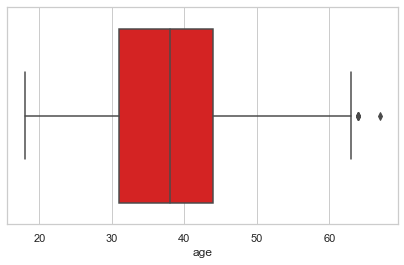

In [14]:
sns.boxplot(x=df_train['age'], palette=customPalette)

Aqui mais um boxplot contendo todo conjunto de dados no atributo *age*. O gráfico indica a presença de dois outliers. Porém, os valores estão corretose não se distanciam muito do último quartil de dados.<br/>
Portanto, não será preciso tratar os valores "*outliers*".

**<h4 id="att_job">1.3) Job</h4>**
O próximo atributo a ser analisado será job. Vamos responder algumas perguntas, tais como:
* Quais são as profissões mais declaradas?
* Ao criar uma conta fraudulenta, quais profissões o indíduos tendem a escolher?
* Existe uma relação entre as profissões e as demais variáveis?

In [15]:
df_train.head()

,accountId,job,city,state,age,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,ranking,ranking_num,age_bin
0,842,Gestor de vendas,Mirassolândia,SP,52,386,291,3783,-2859,41,12499,984,9645,A,0,46-55
1,422,Assistente comercial,Itapetininga,SP,32,441,463,2834,-2998,44,6733,672,4346,A,0,26-35
2,253,Atendente de Telemarketing,Iperó,SP,37,412,534,2068,-2715,49,5206,652,3307,A,0,36-45
3,595,Diretor de compras,General Salgado,SP,36,379,269,1322,-937,52,4370,897,3135,A,0,36-45
4,989,Diretor de compras,Taiaçu,SP,54,0,0,0,0,0,0,0,0,A,0,46-55


In [16]:
barChart(df_train, 'job', title='Quantidade por profissão', xaxis='Profissões', yaxis='Quantidade', width=1300, height=500, percent=True, order=False)

In [17]:
df_ageBin_ocu = df_train.groupby(['age_bin', 'job'], as_index=False)['accountId'].count()
df_ageBin_ocu.sort_values(by=['age_bin', 'job'], ascending=[True, False], inplace=True)
df_ageBin_ocu.columns = ['age_bin', 'job', 'count']
df_ageBin_ocu

,age_bin,job,count
5,0-25,Motorista de aplicativo,13
4,0-25,Gestor de vendas,10
3,0-25,Entregador de aplicativo,5
2,0-25,Diretor de compras,24
1,0-25,Atendente de Telemarketing,22
0,0-25,Assistente comercial,26
11,26-35,Motorista de aplicativo,73
10,26-35,Gestor de vendas,44
9,26-35,Entregador de aplicativo,24
8,26-35,Diretor de compras,51


In [18]:
#Método para criar o Radar plot
def radarPlot(df, iter, r, theta, title = 'Default', rangeMin = 0, rangeMax = 100, width = 1000, height = 600):
  categories = df[theta].unique()
  iters = df[iter].unique()

  fig = go.Figure()

  lista_cores = ['#0A4040', '#21CCCC', '#730202', '#F20505', '#736F6E', '#F2EAE9']
  i = 0
  for it in iters:
    df_temp = df.loc[df[iter] == it]

    fig.add_trace(go.Scatterpolar(
          r=df_temp[r],
          theta=categories,
          fill='toself',
          name=it,
          marker={'color': lista_cores[i]}
    ))
    i += 1

  fig.update_layout(
    title='<span>{}</span>'.format(title),
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[rangeMin, rangeMax]
      )),
    width=width,
    height=height,
    showlegend=True
  )

  fig.show()

In [19]:
radarPlot(df = df_ageBin_ocu, iter = 'age_bin', r = 'count', theta = 'job', 
            title = 'Intervalos de idades por profissão dos clientes', rangeMin = 0, rangeMax = df_ageBin_ocu['count'].max(), width = 800, height = 600)

Com esse agrupamento podemos ter uma ideia geral do perfil de cada grupo de idades dos clientes. Dá para perceber que os grupos estão bem distribuídos, pois quase todos os plots possuem o mesmo formato, exceto pelo segundo grupo [26-35] que possui várias contas categorizadas como *Motorista de Aplicativo*.<br/>

> Segundo este conjunto de dados, aparentemente não há relação clara entre perfil de cliente e idade.


In [20]:
df_ocu_ranking = df_train.groupby(['job', 'ranking'], as_index=False)['accountId'].count()
df_ocu_ranking.columns = ['job', 'ranking', 'count']
df_ocu_ranking.sort_values(by=['job', 'ranking'], ascending=[True, False], inplace=True)
df_ocu_ranking

,job,ranking,count
4,Assistente comercial,F,9
3,Assistente comercial,D,93
2,Assistente comercial,C,88
1,Assistente comercial,B,19
0,Assistente comercial,A,3
9,Atendente de Telemarketing,F,32
8,Atendente de Telemarketing,D,71
7,Atendente de Telemarketing,C,65
6,Atendente de Telemarketing,B,19
5,Atendente de Telemarketing,A,7


In [21]:
radarPlot(df = df_ocu_ranking, iter = 'ranking', r = 'count', theta = 'job', 
            title = 'Classificação dos clientes por ocupação', rangeMin = 0, rangeMax = df_ocu_ranking['count'].max(), width = 600, height = 600)

O mesmo gráfico, mas para uma análise diferente. Agora podemos ver se há relação entre a ocupação e as classificações de contas, incluindo contas fraudulentas.<br/>
É possível notar que os *plots* são diferentes entre si. Ou seja, é um indício de que pode haver relação entre as variáveis.
Nota que a maioria dos registros de contas Fraudes possuem a ocupação *Motorista de aplicativo* e *Gestor de vendas*. <br/>
Não sou expert no assunto (ainda*), mas a profissão de investidor tende a ser a mais arriscada de todas as possibilidades possíveis neste dataset. 

> Uma coisa é certa, a informação da ocupação do indivíduo será relevante para o nosso modelo.

**<h4 id="att_state">1.4) State</h4>**
A próxima análise será sobre os estados.

In [22]:
df_train.head()

,accountId,job,city,state,age,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,ranking,ranking_num,age_bin
0,842,Gestor de vendas,Mirassolândia,SP,52,386,291,3783,-2859,41,12499,984,9645,A,0,46-55
1,422,Assistente comercial,Itapetininga,SP,32,441,463,2834,-2998,44,6733,672,4346,A,0,26-35
2,253,Atendente de Telemarketing,Iperó,SP,37,412,534,2068,-2715,49,5206,652,3307,A,0,36-45
3,595,Diretor de compras,General Salgado,SP,36,379,269,1322,-937,52,4370,897,3135,A,0,36-45
4,989,Diretor de compras,Taiaçu,SP,54,0,0,0,0,0,0,0,0,A,0,46-55


In [23]:
list_state = df_train['state'].value_counts()

fig = go.Figure()
for i in range(len(list_state)):
    fig.add_trace(go.Bar(
        x = [list_state.index[i]],
        y = [list_state[i]],
        text = [str(list_state[i])],
        name = list_state.index[i], 
        marker={'color': list_colors[i]}
    ))

fig.show()

In [24]:
#Agrupamento por State e por ranking, além disso, realizando o count.
df_state_lv = df_train.groupby(['state', 'ranking'], as_index=False)['accountId'].count()
df_state_lv.columns = ['state', 'ranking', 'ranking_count']
df_state_lv.sort_values(by=['ranking', 'ranking_count'], ascending=[False, False], inplace=True)

#Buscando o count total por state e ranking e calculando a porcentagem correspondente.
df_state_lv['count_account'] = df_state_lv['state'].apply(lambda x: np.sum(df_train['state'] == x))
df_state_lv['percent'] = round(df_state_lv['ranking_count'] / df_state_lv['count_account'] * 100, 2)

In [25]:
df_state_lv.head(10)

,state,ranking,ranking_count,count_account,percent
28,RS,F,106,199,53.27
14,MT,F,56,152,36.84
19,PR,F,22,121,18.18
33,SP,F,20,276,7.25
32,SP,D,129,276,46.74
18,PR,D,46,121,38.02
13,MT,D,42,152,27.63
27,RS,D,42,199,21.11
6,MG,D,27,51,52.94
9,MS,D,24,42,57.14


Ordenado por ranking e ranking_count podemos ver que existem somente 4 estados que ocorreram fraudes, destaque para os estados RS e MT, contendo valores bem expressivos em termos de porcentagem de fraudes. 

In [26]:
fig = px.scatter(df_state_lv, x='state', y='percent', color='ranking', size='percent', color_discrete_map={'F': '#F20505', 'D': '#0A4040', 'C': '#148080', 'B': '#1BA6A6', 'A': '#9DF5F5'})
fig.update_layout(
    title_text="<span>Porcentagem de contas fraudulentas por estado</span>",
    autosize=False,
    width=600,
    height=400,
)

fig.show()

O que esse gráfico está nos dizendo?<br/>
Cada círculo corresponde a um tipo de ranking (A, B, C, D ou F). O eixo X divide as classificações em estados enquanto o eixo Y indica a quantidade de leveis em porcentagem de seu respectivo estado.

Quais informações úteis podemos tirar desse gráfico?<br/>
* Os estados RS e MT têm a maior das contas classificadas com fraudes. Isto é um indicativo que estes estados são mais perigosos. 
* Por outro lado, o estado de RJ possui a maior porcentagem em clientes classificadoos como B. Isso é um sinal que podemos olhar com mais carinho para esse estado.
* Somente quatro estados possuem contas fraudulentas.

Eu decidi atribuir uma nota para cada estado de 0 a 1. Essa nota indica a probabilidade da conta ser fraudulenta.

In [27]:
#Método para criar o score para cada state.
def applyScoreState(state):
    score = df_state_lv.loc[(df_state_lv['state'] == state) & (df_state_lv['ranking'] == 'F'), 'percent']

    if len(score) > 0:
        return score.iloc[0] / 100
    return 0        

df_train['score_state'] = df_train['state'].apply(applyScoreState)
df_test['score_state'] = df_test['state'].apply(applyScoreState)

**<h4 id="att_city">1.5) City</h4>**
Agora a análise por cidades.

In [28]:
print('Quantidade de cidades: {}'.format(len(df_train['city'].unique())))

Quantidade de cidades: 685


In [29]:
#Agrupando por cidades e por estaddo para exibir quantos cliente há por cidade.
df_city = df_train.groupby(['city', 'state'], as_index=False)['accountId'].count()
df_city.sort_values(by='accountId', ascending=False, inplace=True)
df_city.columns = ['city', 'state', 'count_accounts']
print('Top 10 cidades com mais clientes')
df_city.head(10)

Top 10 cidades com mais clientes


,city,state,count_accounts
514,Rebouças,PR,5
489,Porto Barreiro,PR,4
231,Feliz Natal,MT,4
171,Cornélio Procópio,PR,4
187,Cruzeiro do Oeste,PR,4
166,Confresa,MT,4
416,Novo Cabrais,RS,4
307,Ivaté,PR,4
260,Guaraci,PR,4
525,Ribeirãozinho,MT,4


In [30]:
#Agrupamento por cidate, estado e ranking, para ver quantos clientes há por cidade e quais suas classificações.
df_city = df_train.groupby(['city', 'state', 'ranking'], as_index=False)['accountId'].count()
df_city.sort_values(by='accountId', ascending=False, inplace=True)
df_city.columns = ['city', 'state', 'ranking', 'count_accounts']

#Buscando total de clientes por cidade e realização do calculo de porcentagem da classificação dos clientes por cidade.
df_city['total_accounts'] = df_city['city'].apply(lambda x: np.sum(df_train['city'] == x))
df_city['percent'] = round(df_city['count_accounts'] / df_city['total_accounts'] * 100, 2)

#Quero somente os clientes cujo avaliação é Fraude.
df_city = df_city.loc[df_city['ranking'] == 'F']

print('Top 15 cidades com mais contas fraudes')
df_city.head(15)

Top 15 cidades com mais contas fraudes


,city,state,ranking,count_accounts,total_accounts,percent
727,São José do Rio Claro,MT,F,4,4,100.0
506,Novo Cabrais,RS,F,3,4,75.0
513,Novo Santo Antônio,MT,F,3,3,100.0
675,Santa Carmem,MT,F,3,3,100.0
820,Vista Gaúcha,RS,F,3,3,100.0
550,Pelotas,RS,F,2,2,100.0
613,Presidente Lucena,RS,F,2,2,100.0
134,Campina da Lagoa,PR,F,2,2,100.0
332,Ibirapuitã,RS,F,2,2,100.0
118,Brasnorte,MT,F,2,2,100.0


Aqui temos as cidades com mais contas fraudulentas, além disso, a sua respectiva porcentagem em relação ao total de clientes da mesma cidade. Como já era de se esperar, as cidades que possuem mais contas F são em sua maioria dos estados do RS e MT. O curioso dos dados é que eles estão bem esparsos em termos de cidade, ou seja, há poucos clientes por cidade.

Acredito que utilizar cidades no modelo possa mais atrapalhar do que ajudar, uma vez que há centenas de categorias diferentes e se fizer o one-hot-encoding dos dados é possível que o modelo perca performance.

Porém, assim como nos estados, vamos atribuir uma nota para cada cidade baseado na porcentagem de ocorrência de fraudes pelo total de clientes para cada uma.

In [31]:
#Aplicando o score por cidade, semelhante ao que foi feito por estado.
def applyScoreCity(city):
    score = df_city.loc[(df_city['city'] == city) & (df_city['ranking'] == 'F'), 'percent']

    if len(score) > 0:
        return score.iloc[0] / 100
    return 0        

df_train['score_city'] = df_train['city'].apply(applyScoreCity)
df_test['score_city'] = df_test['city'].apply(applyScoreCity)

**<h4 id="att_boleto_ranking">1.6) Quantidade de boletos pagos X Ranking</h4>**
Agora vamos analisar os atributos numéricos e verificar como estes se saem se comparados com a variável target (ranking).

In [32]:
df_boletos = df_train.groupby(['ranking'], as_index=False)['boletosCountPaid', 'boletosCountUnpaid' ].sum()
df_boletos

,ranking,boletosCountPaid,boletosCountUnpaid
0,A,6569,4402
1,B,16336,7825
2,C,24535,13037
3,D,32258,17028
4,F,6308,9413


In [33]:
#Criação do gráfico de barras para exibir as informações lado a lado.
def barChartCountsPaidUnpaid(df, list_cols, title, xaxis, yaxis, width, height, name1, name2):
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x = df[list_cols[0]].values,
        y = df[list_cols[1]].values,
        text = df[list_cols[1]].values,
        name = name1,
        marker={'color': '#148080'}
    ))

    fig.add_trace(go.Bar(
        x = df[list_cols[0]].values,
        y = df[list_cols[2]].values,
        text = df[list_cols[2]].values,
        name = name2,
        marker={'color': '#F20505'}
    ))

    fig.update_layout(
        title='<span>{}</span>'.format(title), 
        autosize=False,
        width=width,
        height=height,
        xaxis=dict(title='<span>{}</span>'.format(xaxis)),
        yaxis=dict(title='<span>{}</span>'.format(yaxis))
        )

    fig.show()

barChartCountsPaidUnpaid(df_boletos, list_cols = ['ranking', 'boletosCountPaid', 'boletosCountUnpaid'], 
                            title = 'Quantidades de boletos pagos e não pagos por classificação de cliente',
                            xaxis = 'Classificação do cliente', yaxis = 'Quantidade', width = 1000, height = 500,
                            name1 = 'Boletos pagos',
                            name2 = 'Boletos não pagos'
                        )

Interessante, o único tipo de conta cujo a quantidade de boletos não pagos é maior que os boletos pagos são as contas classificadas como [Fraude]. Faz sentido que as contas fraudulentas não paguem o que devem.<br/>
Esse atributo vai ser relevante para a construção do nosso modelo.

**<h4 id="att_pix_ranking">1.7) Quantidade de PIX enviado e Recebido X ranking</h4>**
Agora a mesma análise para os pix enviados e os pix recebidos, será que o padrão irá se repetir? Vejamos

In [34]:
df_pix = df_train.groupby(['ranking'], as_index=False)['pixSendCount', 'pixReceiveCount'].sum()
df_pix

,ranking,pixSendCount,pixReceiveCount
0,A,651,10531
1,B,1447,24157
2,C,2331,35631
3,D,2980,46848
4,F,2915,15427


In [35]:
barChartCountsPaidUnpaid(df_pix, list_cols = ['ranking', 'pixReceiveCount', 'pixSendCount'], 
                            title = 'Quantidades de pix enviados e recebidos por classificação de cliente',
                            xaxis = 'Classificação do cliente', yaxis = 'Quantidade', width = 1200, height = 400,
                            name1 = 'Pix recebido pelo cliente',
                            name2 = 'Pix enviado pelo cliente para uma conta externa'
                        )

É sutil, mas há um padrão nos dados. Perceba que as contas F possuem uma proporção maior entre pix recebido e pix enviado do que as demais.

**<h4 id="att_mat_corr">1.8) Matriz de correlação</h4>**

Agora eu vou pegar somente as colunas com valores numéricos para verificar a correlação entre as colunas numéricas e a variável ranking.

In [36]:
df_corr = df_train[['ranking', 'boletosCountPaid', 'boletosCountUnpaid', #'boletos_count_total', 'boletos_sum_total',
                    'boletosSumPaid', 'boletosSumUnpaid', 'pixSendCount', 
                    'pixSendSum', 'pixReceiveCount', 'pixReceiveSum']]

#Mapeamento do ranking para números somente para utilizar a matriz de correlação
ranking_map = {
    'F': 0, 'D': 1, 'C': 2, 'B': 3,'A': 4
}

df_corr['ranking'] = df_corr['ranking'].map(ranking_map)
df_corr.head()

,ranking,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum
0,4,386,291,3783,-2859,41,12499,984,9645
1,4,441,463,2834,-2998,44,6733,672,4346
2,4,412,534,2068,-2715,49,5206,652,3307
3,4,379,269,1322,-937,52,4370,897,3135
4,4,0,0,0,0,0,0,0,0


<AxesSubplot:>

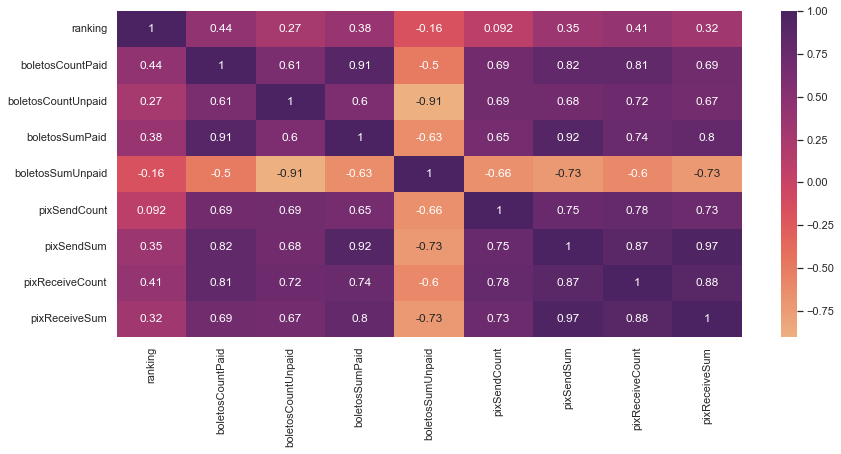

In [37]:
plt.figure(figsize=(14, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='flare')

Esta é a matriz de correlação, ela indica o quão relevantes são os atributos comparados entre si. O que nos interessa são os valores contidos na primeira linha ou primeira coluna, que nos mostra a relevancia dos atributos com a variável ranking.

Nota que as variáveis numéricas não possuem uma correlação muito forte com a variável ranking, a correlação fica em torno de 35~40%. Porém, com esse nível de significancia esses atributos serão úteis para o modelo.

No entanto, há alguns pontos que eu quero levantar:
* A variável ranking é categórica, portanto uma matriz de correlação pode não ser o indicado para esse tipo de análise.
* O que me levou a querer visualizar esse gráfico? Acredito que as classificações de contas são ordinais e seguem uma lógica: 
    * F - Fraude
    * D - Conta comum
    * C - Conta um pouco melhor
    * B - Conta especial
    * A - Conta mais especial<br/>
    
Por isso eu substitui por [0, 1, 2, 3, 4, 5], representando em números seu nível de importância.

<hr/>

<h3 id="pre00">2. PRÉ PROCESSAMENTO DOS DADOS</h3>

In [38]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

Agora vou realizar a etapa de pré-processamento dos dados. É uma etapa muito importante para selecionar os atributos que irão para o modelo e para realizar a padronização dos dados. Este dataset é bastante limpo, não há vaores faltantes e também não precisaremos lidar com os valores outliers, pois os mesmos não irão impactar diretamente na precisão do nosso modelo.

Esta etapa terá os seguintes passos:
* Selecionar os atributos relevantes para o modelo;
* Realizar o one-hot-encoding das variáveis categóricas;
* Separar os dados em treino e teste.

Eu criei essa classe para não precisar criar várias instâncias das variáveis [onehotencoder].
A classe faz isso automaticamente para mim, além disso, ela atribui o nome da coluna no dataframe, coisa que o objeto onehotencoding não faz. 
Isso pode ser interessante para sabermos exatamente de qual atributo estamos análisando em uma análise a posteriori.<br/>

A classe possui dois métodos:
* fit_transform: Treinar e transformar os dados;
* transform: Transformar novos dados com o modelo já treinado.

O construtor possui dois parâmetros:
* **df**: Dataframe que será realizado o treinamento
* **cols**: Lista de colunas que será realizado a transformação

In [39]:
class MyHotEncoder:
    def __init__(self, df, cols):
        self.df = df
        self.list_oneHotEncoder = []
        self.list_col = []

        if isinstance(cols, list):
            self.list_col = cols
        else:
            self.list_col.append(cols)

    #Treina os dados passados.
    def fit_transform(self):

        self.df.reset_index(drop=True, inplace=True) #Reseta o index do dataset para não causar problemas
        X = self.df.values

        #Para cada coluna crie uma string contendo o nome do atributo e o nome da categoria.
        #Exemplo de saída: [sex_male]
        for col in self.list_col: 
            valores = list(self.df[col].sort_values().unique())
            colunas = []
            for i in valores:
                colunas.append(col + '_' + str(i))
            colunas = colunas + list(self.df.columns)
            
            #One hot encoder para treinar
            onehotencoder = OneHotEncoder(handle_unknown='ignore')
            self.list_oneHotEncoder.append(onehotencoder)

            enc_df = onehotencoder.fit_transform(self.df[[col]]).toarray()
            enc_df = pd.DataFrame(enc_df)
            
            #União do dataset gerado ao dataset original
            self.df = enc_df.join(self.df)
            self.df.columns = colunas
            self.df.drop(col, axis=1, inplace=True)
        
        return self.df

    #Apenas aplica a transformação a novos dados.
    def transform(self, df):
        
        for i in range(len(self.list_col)):
            col = self.list_col[i]

            valores = list(df[col].sort_values().unique())
            colunas = []
            for j in valores:
                colunas.append(col + '_' + str(j))
            colunas = colunas + list(df.columns)

            #One hot encoder para transformar
            enc_df = self.list_oneHotEncoder[i].transform(df[[col]]).toarray()
            enc_df = pd.DataFrame(enc_df)

            #União do dataset gerado ao dataset original
            df = enc_df.join(df)
            df.columns = colunas
            df.drop(col, axis=1, inplace=True)


        return df       

**<h4 id="col_sel">2.1) Seleção das colunas relevantes para o modelo</h4>**

Agora vamos escolher somente as colunas que foram relevantes nas análises anteriores. Vamos excluir:
* **accountId**: Para um modelo de Machine Learning, o id não é útil;
* **birth**: Já temos a idade, portanto a data completa de nascimento também não é útil;
* **email**: Como citado anteriormente, esses emails simulados não indicam informações relevantes;
* **ranking**: Nossa  variável target, deve ser excluída do dataset de treino;
* **boletos_sum_unpaid**: Baixa correlação com a variável target;
* **pix_send_count**: Baixa correlação com a variável target.

Atributos considerados redundantes, pois os mesmos já foram somados em um único atributo: *boletos_sum_total* e *boletos_count_total*, respectivamente:
* **boletos_sum_paid**;
* **boletos_count_paid**; 
* **boletos_count_unpaid**; 
* **city**: São muitas categorias, felizmente temos o estado que agrupa todas as cidades, portanto, podemos excluir também. Além disso, temos nossa variável *score_city* que irá nos auxiliar nesse quesito;
* **state**: Uma vez que obtivemos a sua pontuação respectiva.
<br/>

In [40]:
df_train.columns

Index(['accountId', 'job', 'city', 'state', 'age', 'boletosCountPaid',
       'boletosCountUnpaid', 'boletosSumPaid', 'boletosSumUnpaid',
       'pixSendCount', 'pixSendSum', 'pixReceiveCount', 'pixReceiveSum',
       'ranking', 'ranking_num', 'age_bin', 'score_state', 'score_city'],
      dtype='object')

In [41]:
#Seleção das colunas que irão para o treinamento.
columns_train = ['job', 'age', 'score_state', 'score_city',
                 'pixSendCount', 'pixSendSum', 'pixReceiveCount', 'pixReceiveSum', 
                 'boletosCountPaid', 'boletosCountUnpaid', 'boletosSumPaid', 'boletosSumUnpaid']
column_target = ['ranking_num']

X = df_train[columns_train]
X_test_final = df_test[columns_train]

Y = df_train[column_target]

In [42]:
#my_encoder = MyHotEncoder(X,['job', 'state'])
my_encoder = MyHotEncoder(X,'job')

x_encoded = my_encoder.fit_transform()
x_test_final = my_encoder.transform(X_test_final)

In [43]:
display(x_encoded.head(3))
display(x_test_final.head(3))

,job_Assistente comercial,job_Atendente de Telemarketing,job_Diretor de compras,job_Entregador de aplicativo,job_Gestor de vendas,job_Motorista de aplicativo,age,score_state,score_city,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid
0,0.0,0.0,0.0,0.0,1.0,0.0,52,0.0725,0.0,41,12499,984,9645,386,291,3783,-2859
1,1.0,0.0,0.0,0.0,0.0,0.0,32,0.0725,0.0,44,6733,672,4346,441,463,2834,-2998
2,0.0,1.0,0.0,0.0,0.0,0.0,37,0.0725,0.0,49,5206,652,3307,412,534,2068,-2715


,job_Assistente comercial,job_Atendente de Telemarketing,job_Diretor de compras,job_Entregador de aplicativo,job_Gestor de vendas,job_Motorista de aplicativo,age,score_state,score_city,pixSendCount,pixSendSum,pixReceiveCount,pixReceiveSum,boletosCountPaid,boletosCountUnpaid,boletosSumPaid,boletosSumUnpaid
0,1.0,0.0,0.0,0.0,0.0,0.0,38,0.0725,1.0,8,1176,156,861,64,79,350,-426
1,1.0,0.0,0.0,0.0,0.0,0.0,40,0.1818,0.0,13,1149,70,356,167,42,846,-214
2,0.0,0.0,1.0,0.0,0.0,0.0,32,0.3684,1.0,54,3848,724,2692,350,385,1299,-1426


**<h4 id="pad_data">2.2) Padronização e Normalização dos Dados</h4>**

Agora temos um novo problema, você pode observar que os valores das age, pix_enviado_sum, pix_send_count, etc.. estão em uma escala bem distinta, onde a idade varia entre 18 a 65 enquanto que pix_enviado_sum está na casa dos milhões. Isto pode causar um grande problema no treino do nosso modelo uma vez o os atributos com valores muito grande terão uma influência maior sobre o modelo. Além disso, as bordas dos valores podem representar outliers dos quais queremos reduzir o impacto na solução.

Para solucionar esses problemas vamos utilizar dois tipos de reescala dos dados e analisar qual delas se sai melhor para este conjunto de dados, vamos utilizar o **Normalizer** e o **StandardScaler**.

<h5 id="pad_data_norm">2.2.1) Normalizer</h5>

O Normalizer age reescalando os dados por exemplos/linhas e não por colunas, ou seja, o Normalizer levará em contas os atributos e reescalar os valores com base nesles. O Normalizer é uma boa escolha quando você sabe que a distribuição dos seus dados não é normal/gaussiana ou quando você não sabe qual é o tipo de distribuição dos seus dados.

In [44]:
normalizer = Normalizer()

X_norm = normalizer.fit_transform(x_encoded)
X_norm_final = normalizer.transform(x_test_final)

<h5 id="pad_data_stand">2.2.2) StandardScaler</h5>

O StandardScaler age sobre as colunas. Este subtrai do valor em questão a média da coluna e divide o resultado pelo desvio padrão. No final temos uma distribuição de dados com desvio padrão igual a 1 e variância de 1 também. Esse método trabalha melhor em dados com distribuição normal porém vale a tentativa para outros tipos de distribuições.
> valor = (valor — média) / desvioPadão

In [45]:
standardscaler = StandardScaler()

X_stand = standardscaler.fit_transform(x_encoded)
X_stand_final = standardscaler.transform(x_test_final)

**<h4 id="train_test">2.3) Train Test Split</h4>**
A próxima etapa é dividir o conjunto de dados em treino e teste, isso é necessário para que possamos treinar e testar o modelo com dados separados, e não utilizando o mesmo conjunto de dados. Dessa forma conseguimos ter uma noção melhor se o modelo está sofrendo de overfitting.<br/>

In [46]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size = 0.3, random_state = 0)
X_train, X_test, Y_train, Y_test = train_test_split(X_stand, Y, test_size = 0.3, random_state = 0)

**<h4 id="cross_val">2.4) Cross validation</h4>**
Vamos aplicar também uma validação cruzada para que todos os dados possam ser treinados e testados.

In [47]:
k_fold = KFold(n_splits=15, shuffle=True, random_state=0)

<hr/>

<h3 id="data_model">3. MODELAGEM</h3>


**<h4 id="dumb_model">3.1) Dumb Model</h4>**

Agora a etapa mais esperada para quem trabalha com Ciência de Dados, a construção do modelo de Machine Learning. Primeiro eu vou realizar uma modelagem às cegas, escolhendo alguns modelos só para ter uma primeira versão e verificar como ele se sai com esses dados.

Na segunda parte construirei uma versão mais elaborada e aplicarei técnicas mais avançadas de Machine Learning para otimizar e avaliar o modelo.

<h5 id="knn">3.1.1) KNN - K Nearest Neighbors</h5>


In [48]:
#Criando o modelo KNN
KNN = KNeighborsClassifier(n_neighbors = 8, p=1)

#Utilizando o Cross Validation
scoring = 'accuracy'
score = cross_val_score(KNN, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
print('\nAcurácia no conjunto de treino: {}%'.format(round(np.mean(score) * 100, 2)))

KNN = KNN.fit(X_train, Y_train)
preds = KNN.predict(X_test)
print('Acurácia no conjunto de testes: {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[0.95454545 0.97727273 0.97727273 1.         0.93023256 0.97674419
 0.93023256 1.         1.         0.95348837 0.97674419 0.90697674
 0.97674419 0.97674419 1.        ]

Acurácia no conjunto de treino: 96.91%
Acurácia no conjunto de testes: 96.76%
F1 Score no conjunto de testes: 91.89%


<h5 id="logisticreg">3.1.2) Logistic Regression</h5>

In [49]:
logisticRegression = LogisticRegression(max_iter=100)
scoring = 'accuracy'
score = cross_val_score(logisticRegression, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)

print(score)
print('\nAcurácia no conjunto de treino: {}%'.format(round(np.mean(score) * 100, 2)))

logisticRegression = logisticRegression.fit(X_train, Y_train)
preds = logisticRegression.predict(X_test)
print('Acurácia no conjunto de testes {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[1.         1.         0.97727273 1.         0.97674419 0.97674419
 1.         1.         1.         0.97674419 1.         0.95348837
 0.97674419 1.         1.        ]

Acurácia no conjunto de treino: 98.92%
Acurácia no conjunto de testes 97.84%
F1 Score no conjunto de testes: 94.92%


<h5 id="randforest">3.1.3) Random Forest</h5>

In [50]:
RandomForest = RandomForestClassifier(n_estimators=150, #Quantidade de árvores
                                      bootstrap=True, 
                                      criterion='entropy', 
                                      min_samples_leaf=1, 
                                      min_samples_split=18, 
                                      random_state=8)

scoring = 'accuracy'
score = cross_val_score(RandomForest, X_train, Y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

RandomForest = RandomForest.fit(X_train, Y_train)
preds = RandomForest.predict(X_test)
print('Acurácia no conjunto de testes {}%'.format(round(accuracy_score(Y_test, preds) * 100, 2)))
print('F1 Score no conjunto de testes: {}%'.format(round(f1_score(Y_test, preds) * 100, 2)))

[1.         0.97727273 0.97727273 1.         0.95348837 1.
 0.95348837 1.         1.         0.90697674 1.         0.95348837
 0.97674419 1.         0.97674419]
Acurácia no conjunto de testes 98.2%
F1 Score no conjunto de testes: 95.8%


**<h4 id="automodel">3.2) Realizando uma modelagem automatizada </h4>**

Que legal, nossos três modelos obtiveram ótimos resultados, destaque para a Regressão Logística e para a Random Forest. Porém, nota-se que o código escrito para cada modelo é muito parecido, muda apenas a escolha do algoritmo de Machine Learning. <br/>

O que fazer para melhorar:
* Criar uma função única que receba como entrada o algoritmo e o conjunto de dados;
* Utilizar mais algoritmos;
* Aplicar técnicas para escolher os melhores parâmetros para cada modelo específico;
* Aplicar as duas padronizações que foram definidas (Normalizer e StandardScaler);
* Apresentar os resultados de maneira visual;
* Gerar uma tabela contendo os melhores modelos.

A seguir uma lista com todos os algoritmos que serão utilizados pelo nosso modelo. Se trata de uma lista de dicionários, onde cada dicionário contém informações pertinentes a cada algoritmo:
* **name**: Nome do algotitmo;
* **model**: A instância do objeto;
* **params**: Todos os parâmetros que serão testados pelo GridSearch

> O GridSearch se trata de um algoritmo que recebe como entrada o modelo e os parâmetros. Ele basicamente faz todas as possíveis combinações de parâmetros e retorna os parâmetros que obtiveram os melhores resultados.

In [51]:
list_estimators = [
    {'name': 'Logistic Regression',
     'model': LogisticRegression(),
     'params': {
                'penalty':['l1', 'l2', 'elasticnet'],
                'fit_intercept': [True, False],
                'solver': ['newton-cg', 'lbfgs', 'liblinear']}
    },
    
    {
       'name': 'Naive Bayes',
       'model': GaussianNB(),
       'params': {}
    },

     {'name': 'KNN',
     'model': KNeighborsClassifier(),
     'params': {
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'p': [1, 2]
     }
    },

    {'name': 'SVM - Support Vector Machine',
     'model': SVC(),
     'params': {}
    },

    {'name': 'Random Forest',
     'model': RandomForestClassifier(),
     'params': {
            'n_estimators': [100],
            'bootstrap': [True, False], 
            'criterion': ['entropy'], 
            'min_samples_leaf': [1, 5, 10], 
            'min_samples_split': [10, 20, 30]
     }
    },

    {
       'name': 'XGB - Extreme Boosting Classifier',
       'model': XGBClassifier(),
       'params': {
          'eta': [0.3],
          'max_depth': [3],
          'gamma': [0, 1],
          'scale_pos_weight': [0, 2]
          #'alpha': [0.5, 1, 1.5],
          #'lambda': [0.5, 1, 1.5]
       }
    }
    
    ]

Abaixo estou criando uma função para exibir de maneira visual a matriz de confusão do nosso modelo. A matriz de confusão serve para analisarmos todos os valores verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos previstos pelo modelo.

In [62]:
x_axes = ['Normal', 'Fraude']
y_axes =  ['Fraude', 'Normal']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='magma')

    # add title
    fig.update_layout(
        title_text='<span><b>Confusion matrix</b></span>',
        xaxis = dict(title='Valores previstos'),
        yaxis = dict(title='Valores reais'),
        width=280,
        height=280
        )

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()
    #return fig

<h5 id="metrics">3.2.1) Métricas de avaliação</h5>

Por hábito vou utilizar a métrica **acurácia** para ver os acertos brutos previstos. Porém, essa não é a métrica adequada para tirar as conclusões finais do nosso modelo, pois o dataset está desbalanceado. Por exemplo, se temos um dataset com 1000 registros, sendo 900 de uma classe e 100 de outra e o nosso modelo classicar todos os 1000 registros como primeira classe, a acurácia daria 90%.

Então vamos nos basear em outra métrica para tirar nossas conclusões, eu escolhi a **F1 Score** (F-Measure em inglês). Ela une através da média harmônica outras duas métricas, a *precision* e o *recall*. Ela é muito boa quando o dataset possui classes desproporcionais, que é o casso deste dataset como vimos lá no início das análises. Quase 80% dos valores são contas normais enquanto que apenas 20% são contas Fraudes.


In [63]:
def autoModel(X_train, Y_train, X_test, Y_test):

    #Inicializando variáveis
    list_all_results = []
    list_standardization = [Normalizer(), StandardScaler()]

    best_acc = 0
    best_model = {
        'name': 'null',
        'model_grid': 'null',
        'best_params': 'null',
        'stand': 'null',
        'acc_train': 0,
        'acc_test': 0
    }

    #Para cada tipo de padronização iteramos
    for stand in list_standardization:

        #Para cada algoritmo na lista de algoritmos
        for estimator in list_estimators:
            
            #Criação do objeto GridSearch
            model_grid = GridSearchCV(estimator=estimator['model'], param_grid=estimator['params'], cv=10)
            
            #Criação do pipeline de execução
            pipe = Pipeline(steps=[('scale', stand), ('grid', model_grid)])
            pipe.fit(X_train, Y_train)

            #Realizando as previsões para cada dataset. Treino e teste
            preds_train = pipe.predict(X_train)
            preds_test = pipe.predict(X_test)
            
            #Otendo os resultados para cada métrica
            acc_train = accuracy_score(preds_train, Y_train)
            acc_test = accuracy_score(preds_test, Y_test)
            f1_train = f1_score(preds_train, Y_train)
            f1_test = f1_score(preds_test, Y_test)

            #Exibindo os resultados por acurácia, f1 score e matriz de confusão de treino e teste para cada algoritmo.
            print('Algoritmo: [{}]'.format(estimator['name'])) 
            print('stand:[{}] [ACCURACY] train:[{}%]  test:[{}%]'.format(stand, round(acc_train * 100, 2), round(acc_test * 100, 2)))
            print('stand:[{}] [F1 SCORE] train:[{}%]  test:[{}%]'.format(stand, round(f1_train * 100, 2), round(f1_test * 100, 2)))
            conf_matrix(confusion_matrix(preds_test, Y_test))

            #Armazenando sempre o melhor resultado
            if acc_test > best_model['acc_test']:
                best_model['name'] = estimator['name'],
                best_model['model_grid'] = pipe['grid'].estimator,
                best_model['best_params'] =  pipe[1].best_params_,
                best_model['stand'] = stand
                best_model['acc_train'] = acc_train
                best_model['acc_test'] = acc_test

            #Armazenando todos os resultados em uma lista para exibir em um dataframe final
            list_all_results.append(
                {'name': estimator['name'],
                'standardization': re.sub(r'[()]', '', str(stand)),
                'f1 score': round(f1_test * 100, 2)
                })

    return best_model, list_all_results

<h5 id="autotrain">3.2.2) Treinando e obtendo os resultados</h5>

Com todas as funções criadas, agora é só realizar a chamada da função passando os dados de treino e teste.

In [64]:
best_model, list_all_results = autoModel(X_train, Y_train, X_test, Y_test)

Algoritmo: [Logistic Regression]
stand:[Normalizer()] [ACCURACY] train:[99.38%]  test:[98.2%]
stand:[Normalizer()] [F1 SCORE] train:[98.6%]  test:[95.73%]


Algoritmo: [Naive Bayes]
stand:[Normalizer()] [ACCURACY] train:[95.68%]  test:[96.4%]
stand:[Normalizer()] [F1 SCORE] train:[90.79%]  test:[91.94%]


Algoritmo: [KNN]
stand:[Normalizer()] [ACCURACY] train:[100.0%]  test:[97.84%]
stand:[Normalizer()] [F1 SCORE] train:[100.0%]  test:[94.83%]


Algoritmo: [SVM - Support Vector Machine]
stand:[Normalizer()] [ACCURACY] train:[99.69%]  test:[98.92%]
stand:[Normalizer()] [F1 SCORE] train:[99.31%]  test:[97.44%]


Algoritmo: [Random Forest]
stand:[Normalizer()] [ACCURACY] train:[99.69%]  test:[98.92%]
stand:[Normalizer()] [F1 SCORE] train:[99.3%]  test:[97.44%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[Normalizer()] [ACCURACY] train:[100.0%]  test:[98.56%]
stand:[Normalizer()] [F1 SCORE] train:[100.0%]  test:[96.61%]


Algoritmo: [Logistic Regression]
stand:[StandardScaler()] [ACCURACY] train:[99.54%]  test:[97.48%]
stand:[StandardScaler()] [F1 SCORE] train:[98.95%]  test:[94.12%]


Algoritmo: [Naive Bayes]
stand:[StandardScaler()] [ACCURACY] train:[94.6%]  test:[94.96%]
stand:[StandardScaler()] [F1 SCORE] train:[88.75%]  test:[89.06%]


Algoritmo: [KNN]
stand:[StandardScaler()] [ACCURACY] train:[100.0%]  test:[98.2%]
stand:[StandardScaler()] [F1 SCORE] train:[100.0%]  test:[95.65%]


Algoritmo: [SVM - Support Vector Machine]
stand:[StandardScaler()] [ACCURACY] train:[99.54%]  test:[99.28%]
stand:[StandardScaler()] [F1 SCORE] train:[98.95%]  test:[98.31%]


Algoritmo: [Random Forest]
stand:[StandardScaler()] [ACCURACY] train:[99.85%]  test:[98.56%]
stand:[StandardScaler()] [F1 SCORE] train:[99.65%]  test:[96.61%]


Algoritmo: [XGB - Extreme Boosting Classifier]
stand:[StandardScaler()] [ACCURACY] train:[100.0%]  test:[99.64%]
stand:[StandardScaler()] [F1 SCORE] train:[100.0%]  test:[99.16%]


<h5 id="finalsel">3.2.3) Selecionando o melhor modelo</h5>

Agora que temos o nosso dataframe, podemos visualizar como cada modelo se saiu. Além disso, temos os melhores parâmetros para aplicar no modelo. Agora vamos treiná-lo novamente, mas dessa vez, iremos utilizar todos os dados disponíveis para o treinamento e aplicar o modelo nos dados que foram separados lá no início do projeto.

In [55]:
df_resultados = pd.DataFrame(list_all_results).sort_values(by='f1 score', ascending=False).reset_index(drop=True)
display(df_resultados)

,name,standardization,f1 score
0,XGB - Extreme Boosting Classifier,StandardScaler,99.16
1,SVM - Support Vector Machine,StandardScaler,98.31
2,SVM - Support Vector Machine,Normalizer,97.44
3,Random Forest,Normalizer,96.67
4,XGB - Extreme Boosting Classifier,Normalizer,96.61
5,Logistic Regression,Normalizer,95.73
6,KNN,StandardScaler,95.65
7,Random Forest,StandardScaler,94.92
8,KNN,Normalizer,94.83
9,Logistic Regression,StandardScaler,94.12


In [65]:
#Selecionando o melhor algoritmo e seus melhores parâmetros
estimator = best_model['model_grid'][0]
params = best_model['best_params'][0].copy()

#Convertendo para o formato que o GridSearch aceita. Formato de lista.
for key in params:
    lst = [params[key]]
    params[key] = lst

#Criação do modelo GridSearch final
final_model = GridSearchCV(estimator=estimator, param_grid=params, cv=10)

#Seleção da melhor padronização
stand = best_model['stand']
#Criação do pipeline de execução
pipe = Pipeline(steps=[('scale', stand), ('grid', final_model)])


#Treinamento e previsões tanto para o conjunto de treino quanto para o conjunto de testes final.
pipe.fit(x_encoded, Y)
predsTrain = pipe.predict(x_encoded)
predsFinal = pipe.predict(x_test_final)


#Obtendo a métrica de avaliação
f1_train = f1_score(predsTrain, Y)

#Exibindo os resultados do último treino. Vale ressaltar que estes resultados não são 100% confiáveis, uma vez que o modelo já viu os dados.
print('stand:[{}] [F1 SCORE] final train:[{}%]'.format(stand, round(f1_train * 100, 2)))
conf_matrix(confusion_matrix(predsTrain, Y))

stand:[StandardScaler()] [F1 SCORE] final train:[100.0%]


In [66]:
df_final = pd.DataFrame({
        "accountId": df_test['accountId'],
        "previsoes": predsFinal
    })

df_final.to_csv('previsoes.csv', index=False)

<hr/>

<h3 id="final">4. CONSIDERAÇÕES FINAIS </h3>

Pelas análises podemos verificar que o dataset possui bastante contas consideradas fraudes, com cerca de 20% dos registros para essa categoria. As principais ocupações declaradas pelas contas Fraude são:
* **Motorista de aplicativo**;
* **Gestor de vendas**;<br/>

Outro ponto relevante são os estados declarados pelos clientes. O estado do **Rio Grande do Sul (RS)** e o estado do **Mato Grosso (MT)** são campeões em porcentagem de contas fraudulentas.
No RS, mais de 50% das contas dos clientes são Fraudes, enquanto que no estado do MT temos 36% de contas Fraudes. Em terceiro lugar, com um nível também expressivo de contas fraudes, temos o **Paraná (PR)**. De todos os estados, 4 deles possuem contas Fraudes.

Há uma associação muito clara sobre os boletos pagos e não pagos e a classificação do cliente. O único caso onde a soma total de boletos não pagos é maior que a quantidade de boletos pagos é justamente nas contas consideradas Fraudes. Não quer dizer que todos os clientes que possuem menos boletos pagos do que não pagos são Fraudes, mas é um bom indicativo.

Uma dependência que não é tão clara, mas acontece é sobre a quantidade de pix recebido e pix enviado pelo cliente para uma conta externa. Foi possível notar que as contas Fraudes possuem uma proporção maior do que as outras nesse indicativo. Ou seja, contas Fraude enviam mais pix do que contas normais.

A análise por cidades nos retornou que há poucas contas por cidade, mas há bastante cidades. Por um lado é bom, porque o alcance da empresa está indo longe, mas por outro lado é ruim, porque são clientes muito específicos que estão buscando a empresa.


O clientes lícitos estão mais distribuídos na faixa dos 38 até os 43 anos de idade. Direcionar os esforçõs para trazer clientes nessa faixa etária pode ser relevante para a empresa.
Além disso há uma boa quantidade de clientes bem jovens (menos que 20 anos) e clientes mais velhos (entre 54 e 59) anos. <br/>

<hr/>

### FIM
Este foi o meu projeto para a resolução do problema de negócio. Espero que quem ler tenha gostado. 

> email: krupck@outlook.com

Atenciosamente.